In [1]:
from tools.train import train_model, main, get_param_dict
from tools.utils import accuracy
from model import SSD300
from datasets import PascalVOCDataset, MSCoCoDataset
from config import Config
import torch
import time
import os
print(torch.__version__)


def load_model(checkpoint: str):
    checkpoint = torch.load(checkpoint)
    start_epoch = checkpoint['epoch'] + 1
    print('\nLoaded checkpoint from epoch %d.\n' % start_epoch)
    model = checkpoint['model']
    optimizer = checkpoint['optimizer']
    
    return model, optimizer, start_epoch

2.0.1+cu118


## Загрузка датасета формате PascalVOC или MSCoCo

In [2]:
# data_folder = r'C:\Users\maxxx\MMCP\ssd_torch\a-PyTorch-Tutorial-to-Object-Detection\data'
# ####data_folder = r'C:\Users\maxxx\fiftyone\coco-2017\validation'
# data_folder = r'C:\Users\maxxx\MMCP\FiftyOne_test\HRSID'
data_folder = r'C:\Users\maxxx\MMCP\FiftyOne_test\coco2017'

DataSetType = 'MSCOCO'      # 'MSCOCO'  or 'PascalVOC'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


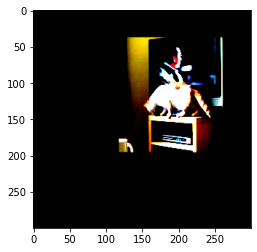

In [3]:
if DataSetType == 'MSCOCO':
    Config.set_labels(DataSetType = 'MSCOCO', path_to_labels_json=f'{data_folder}\labels.json')
    train_dataset = MSCoCoDataset(data_folder=data_folder, label_file=f'{data_folder}\labels.json', split='train')
    
elif DataSetType == 'PascalVOC':
    train_dataset = PascalVOCDataset(data_folder=data_folder, split='train')
    
n_classes = len(Config.label_map)
train_dataset.show_img(1) #  automatically used augmentation 

## Инициализация модели

In [8]:
lr = 1e-3
momentum = 0.9 
weight_decay = 5e-4
start_epoch = 0

model = SSD300(n_classes=n_classes)
# Initialize the optimizer, with twice the default learning rate for biases, as in the original Caffe repo
biases = list()
not_biases = list()
for param_name, param in model.named_parameters():
    if param.requires_grad:
        if param_name.endswith('.bias'):
            biases.append(param)
        else:
            not_biases.append(param)
            
            
optimizer = torch.optim.SGD(params=[{'params': biases, 'lr': 2 * lr}, {'params': not_biases}],
                lr=lr, momentum=momentum, weight_decay=weight_decay)


C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Loaded base model.



In [4]:
checkpoint = f'{os.getcwd()}/_models/checkpoint_ssd300.pth.tar' 
model, optimizer, start_epoch = load_model(checkpoint=checkpoint)


Loaded checkpoint from epoch 3.



In [5]:
from model.model import PredictionConvolutions
model.pred_convs = PredictionConvolutions(n_classes)
model.pred_convs

PredictionConvolutions(
  (loc_conv4_3): Conv2d(512, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (loc_conv7): Conv2d(1024, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (loc_conv8_2): Conv2d(512, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (loc_conv9_2): Conv2d(256, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (loc_conv10_2): Conv2d(256, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (loc_conv11_2): Conv2d(256, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (cl_conv4_3): Conv2d(512, 108, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (cl_conv7): Conv2d(1024, 162, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (cl_conv8_2): Conv2d(512, 162, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (cl_conv9_2): Conv2d(256, 162, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (cl_conv10_2): Conv2d(256, 108, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (cl_conv11_2): Conv2d(256, 108, kernel_size=(3, 3

In [5]:
import torch
device =  torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', classes=5, device=device)

Using cache found in C:\Users\maxxx/.cache\torch\hub\ultralytics_yolov5_master
WARNING  invalid check_version(5.8.0, ) requested, please check values.
requirements: Ultralytics requirements ['gitpython>=3.1.30', 'setuptools>=65.5.1'] not found, attempting AutoUpdate...
requirements:  Command 'pip install --no-cache "gitpython>=3.1.30" "setuptools>=65.5.1" ' returned non-zero exit status 1.
YOLOv5  2023-9-24 Python-3.9.7 torch-2.0.1+cu118 CPU

Overriding model.yaml nc=80 with nc=5

                 from  n    params  module                                  arguments                     
  0                -1  1      3520  models.common.Conv                      [3, 32, 6, 2, 2]              
  1                -1  1     18560  models.common.Conv                      [32, 64, 3, 2]                
  2                -1  1     18816  models.common.C3                        [64, 64, 1]                   
  3                -1  1     73984  models.common.Conv                      [64, 128, 

In [8]:
model.eval()

DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C3(
      (cv1): Conv(
        (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
     

In [ ]:
params={'epochs': 10,
         'start_epoch': start_epoch,
         'batch_size': 8,
         'print_freq': 10,
         'save_model_at_end': False,
         'workers': 4,
         'decay_lr_at': [80000, 100000],
         'decay_lr_to': 0.1,
         'grad_clip': None,
         'save_per_step': None
        }
t_start = time.time()
train_model(train_dataset=train_dataset, model=model, optimizer=optimizer, **params)
t_end = time.time()

print(f'time = {t_end - t_start}')

used device = cuda


C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch: [3][0/4]	Batch Time 26.788 (26.788)	Data Time 6.170 (6.170)	Loss nan (nan)	
Epoch: [4][0/4]	Batch Time 7.981 (7.981)	Data Time 7.483 (7.483)	Loss nan (nan)	


Colab's time = 561.9 sec per 3 epochs 

My time      = 623.3653748035431 sec per 3 epochs

# Detect

In [4]:
from utils.detect import detect
from torchvision import transforms
from PIL import Image, ImageDraw, ImageFont
import os

In [7]:
checkpoint = f'{os.getcwd()}/_models/checkpoint_ssd300.pth.tar' 
model = load_model(checkpoint)[0]
# checkpoint = torch.load(checkpoint)
# model = checkpoint['model']
# optimizer = checkpoint['optimizer']


Loaded checkpoint from epoch 3.



In [8]:
img_path = r'C:\Users\maxxx\MMCP\ssd_torch\a-PyTorch-Tutorial-to-Object-Detection\img\000001.jpg'
original_image = Image.open(img_path, mode='r')
original_image = original_image.convert('RGB')
detect(model, original_image, min_score=0.3, max_overlap=0.1, top_k=200).show()

C:\Users\maxxx\MMCP\ssd_torch\obd\model\model.py:505: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen/native/IndexingUtils.h:28.)
  image_boxes.append(class_decoded_locs[1 - suppress])
C:\Users\maxxx\MMCP\ssd_torch\obd\model\model.py:507: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen/native/IndexingUtils.h:28.)
  image_scores.append(class_scores[1 - suppress])


In [5]:
!pip install psutil